# Evaluating Regression Models

In this lesson, we will discuss how to evaluate a model's performance, i.e. measure how well a model predicts the target variable. Knowing how well a model performs requires establishing a baseline, computing metrics, and comparing those metrics across multiple models (including the baseline).

- You will learn ways to define "good enough" and have a baseline.

- You will learn about various regression evaluation metrics, how to compute them manually, how to compute them using sklearn.metrics, and why you would use one over another.

- You will learn how to select your best model using these evaluation metrics.

## Sample Scenario

My students have just completed the first exam in the spring semester literature class. I want to know if there is anyone I should be concerned about at this point so that we can get ahead of a problem before it forms.

I have the data from last semester's class. Neither the content nor the exams have changed in any way, so I'm hoping I can use that data to find the line that most closely predicts final grades. Once I find the "Line of Best Fit" or the "Regression Line", I can use the equation to calculate the current students' final grades using their first exam grades.

There are 3 questions we need to answer:

1. How do we know if our model is good enough?
2. How do we find the line of best fit?
3. How do we evaluate our model?
4. Are our features valuable?

First, we will generate the sample data.

In [2]:
import pandas as pd
import numpy as np

In [3]:
# generate our student grade data
df = pd.DataFrame(np.array([[100, 96], [93, 90], [84, 89], [80, 85], [76, 80], [70, 68], [79, 75]]), columns = ['x', 'y'])

x = df['x']
y = df['y']

df.head(3)

,x,y
0,100,96
1,93,90
2,84,89


## Line of Best Fit
When we are evaluating linear models, we are comparing the predicted points that fall on the **Line of Best Fit** to the actual data points.

Building a linear model is basically finding this line of best fit. You are using a linear regression algorithm to return the slope and y-intercept of the line that most accurately predicts y, given the x and y you provided to the algorithm. The slope and y-intercept, when input into the linear function y=mx+b, give you the **line of best fit**, or the **regression line**.

Establishing a baseline in a simple regression problem is setting that line of best fit to be a constant value. Take a look at the chart below. Which line is the line of best fit? Which is the baseline?

In [5]:
import viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc("axes.spines", top=False, right=False)
viz.evaluation_example1(df, x, y)

AttributeError: module 'viz' has no attribute 'evaluation_example1'

## Establish a Baseline

The very basic baseline is one that uses no model at all. This means, predict the target variable without using any features. The simples way to do this in regression is to take mean or median value and predict all future values to be that constant value. In other words, any model we build should perform better than it would if we had no inputs (i.e. no data for exam 1). As you can see above, as exam 1 changes, the final grade predicted is not impacted in any way. That tells us that the function for that line does not include x, or exam 1, in it at all. (You could also think of it as having a coefficient, or slope, of 0.)

In our sample scenario, we could define our baseline by predicting all final grades for this semester to be the mean or the median final grade of those from last semester. Later we will evaluate both models and if our regression line does not perform better than our baseline, then we do not more forward with the model as is. Let's set the baseline predictions to be the mean of all final grades.

baseline predictions: ^y=μy

In [6]:
df['yhat_baseline'] = df['y'].mean()
df.head(3)

,x,y,yhat_baseline
0,100,96,83.285714
1,93,90,83.285714
2,84,89,83.285714


## Build a Simple Model
We want to find the regression line where exam 1 is the feature or single independent variable and final grade is our target or dependent variable. We have a labeled dataset, so this is supervised machine learning. In short, we are going to provide a regression algorithm with our labeled data (our x and y values) and get in return the parameters needed for the optimal regression line. The parameters needed in a simple regression problem is the y-intercept and the slope/coefficient.

We will go into this in more detail in the modeling lesson, but for now we will wave the magic wand to find that line.

In [7]:
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('y ~ x', data=df).fit()

# compute predictions and add to original dataframe
df['yhat'] = ols_model.predict(x)

df.head(3)

,x,y,yhat_baseline,yhat
0,100,96,83.285714,97.635214
1,93,90,83.285714,91.676524
2,84,89,83.285714,84.015350


Let's plot our line of best fit and compare visually to our baseline (and a couple other lines we "guessed")

In [8]:
viz.evaluation_example2(df, x, y)

AttributeError: module 'viz' has no attribute 'evaluation_example2'

How could we determine which line is best, numerically? We will do that next.

## Evaluate Part 1: RMSE

**Is it "good enough"**

Now we need to measure the performance of the baseline and the line created from our model. We need to determine if our model is "good enough". To determine this, we have to answer two questions.

1. Is the model better than having no model at all? In other words, is using a variable input better than just predicting based on the existing value of the dependent variable (such as the mean or previous value)? We will compute evaluation metrics, such as Mean Squared Error, Root Mean Squared Error, or Median Absolute Error, for the model and the baseline, and compare them to each other.

2. In the case of a simple regression model, "Is our coefficient of determination, or R2, significant?" We will run an F-test and check to p-value of the test statistic to see if the p-value is significant, or less than our alpha (.05).

## Manually

**Manually Compute Evaluation Metrics.**

In this lesson, we will manually compute two common evaluation metric for regression models, the Mean Squared Error (MSE) and the Root Mean Squared Error (RMSE). To do so, we take the following steps:

1. Compute the **residual**, or error, for each data point.
2. Compute the **SSE**, Sum of Squared Errors, a.k.a. **RSS**, Residual Sum of Squares. This is simply squaring each of the errors computed in step one and summing them all together.
3. Compute the **MSE**, Mean Squared Error. We arrive at this by dividing your SSE by the total number of data points, i.e. the average of your errors that have each been squared.
4. Compute the **RMSE**, Root Mean Squared Error. Simply take the square root of the MSE.

We will do this for both the predictions from the model and those from the baseline. We will then compare the final value of each. Whichever has the lower value is the better prediction.

## Residuals
The thick green line is our regression line. It passes through the values for exam1 (x) and the predicted values for final grade (^y)

The residual of an observed value is the difference between the observed value and the estimated value. Another way to state this is that it is the vertical distance from the original data point to the expected data point (which shares an x and sits on the regression line). In this exammple, the residual of an observation is the difference between that students actual final grade and the expected final grade.

The residuals are the foundation for evaluating the effectiveness of a regression model.

Residuals: for each data point, (^y−y)

In [9]:
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [10]:
# compute residuals
df['residual'] = df['yhat'] - df['y']
df['residual_baseline'] = df['yhat_baseline'] - df['y']

In [11]:
df.head()

,x,y,yhat_baseline,yhat,residual,residual_baseline
0,100,96,83.285714,97.635214,1.635214,-12.714286
1,93,90,83.285714,91.676524,1.676524,-6.714286
2,84,89,83.285714,84.015350,-4.984650,-5.714286
3,80,85,83.285714,80.610384,-4.389616,-1.714286
4,76,80,83.285714,77.205418,-2.794582,3.285714


In [ ]:
viz.evaluation_example5(df, x, df.residual_baseline)
viz.evaluation_example5(df, x, df.residual)

Notice the trend that exists in the plot of the baseline residuals the we do not see in the second plot, that of the model residuals. This pattern in the residuals of the baseline indicates there is more information we can use from exam 1 to predict our y, the final exam grade.

Now, we will use the residuals to compute the Sum of Squared Errors, aka Residual Sum of Squares.

## SSE

Sometime the Sum of the Squared Errors (SSE, a.k.a RSS, Residual Sum of Squares) will be used as the final metric to evaluate. Most times, however, this is used as a stepping stone to the other metrics, such as MSE and RMSE. If outliers matter, this is a good metric to use.

The value of the SSE is derived by simply squaring each of the errors computed in step one and summing them all together.

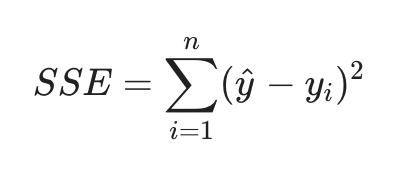

In [12]:
# square each residual value
df['residual^2'] = df.residual ** 2

df['residual_baseline^2'] = df.residual_baseline ** 2

df.head(3)

,x,y,yhat_baseline,yhat,residual,residual_baseline,residual^2,residual_baseline^2
0,100,96,83.285714,97.635214,1.635214,-12.714286,2.673926,161.653061
1,93,90,83.285714,91.676524,1.676524,-6.714286,2.810732,45.081633
2,84,89,83.285714,84.015350,-4.984650,-5.714286,24.846737,32.653061


In [13]:
# SSE
SSE = sum(df['residual^2'])
SSE_baseline = sum(df['residual_baseline^2'])

print("SSE = ", SSE)
print("SSE - baseline = ", SSE_baseline)

SSE =  96.85259593679461
SSE - baseline =  555.4285714285714


At second glance (after visualizing the residual plot), it appears the model is performing better than the baseline. However, it could be do to a single outlier that drastically has increased the SSE. (Well, we know it's not becuase we plotted the residuals, but if we hadn't, that could be the case.)

## MSE
Next, we can use the SSE to compute the Mean Squared Error, MSE. We arrive at this by dividing your SSE by the total number of data points, i.e. the average of your errors that have each been squared. If outliers don't matter as much, but cost exponential instead of linear, then this is a good metric to use. That means that a residual of 10 (the expected value is 10 units off the actual value) is greater than twice a residual of 5.

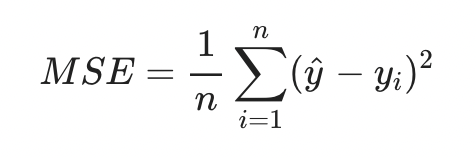

In [14]:
MSE = SSE/len(df)
MSE_baseline = SSE_baseline/len(df)

print("MSE = ", MSE)
print("MSE baseline = ", MSE_baseline)

MSE =  13.836085133827803
MSE baseline =  79.34693877551021


It is clear the model is performing better than the baseline.

## RMSE
Now, we can use the MSE to compute the Root Mean Squared Error, RMSE. Simply take the square root of the MSE. If you want to see the error in the actual units of the y variable, then this is a good metric to use. In this case, the units will be grade points.

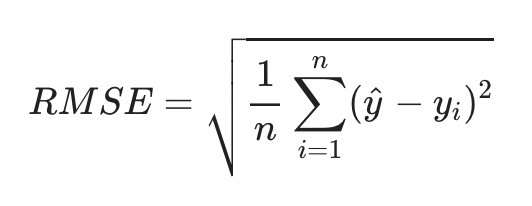

In [16]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline = sqrt(MSE_baseline)

print("RMSE = ", RMSE)
print("RMSE baseline = ", RMSE_baseline)

RMSE =  3.7196888490608733
RMSE baseline =  8.907689867497083


We can see that the model is off by an average of 3.7 grade points, while the baseline is off by an average of 8.9 grade points. The model does better than having no model at all.

# Scikit-Learn

## Use scikit-learn to compute evaluation metrics

Now, instead of manually computing the SSE, MSE, and RMSE, we will use sklearn.metrics to do so.

## SSE
To compute the SSE or RSS, we must use the mean_squared_error function, as sklearn.metrics does not have a function for SSE directly. All we need to do is multiply the MSE by n, the number of data points.

Take a look:

